In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
# Use GridSearchCV to find the best parameters for the model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, RocCurveDisplay, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from xgboost import XGBClassifier

# Anomaly Detection using One class SVM

## Pre-process data

In [21]:
df = pd.read_csv('data_cleaned.csv')

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,2,23,9,302,1023,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0
1,0,3,41,9,48,48,0,0,0,0,...,9,0.08,0.02,0.08,0.00,0.0,0.0,0.0,0.0,0
2,0,2,23,9,334,2096,0,0,0,0,...,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0,0
3,0,2,23,9,211,1796,0,0,0,0,...,255,1.00,0.00,0.05,0.04,0.0,0.0,0.0,0.0,0
4,0,2,23,9,210,396,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0


In [22]:
# process data, 1: normal; [0, 3, 4] -> -1: abnormal

df['target'] = df['target'].apply(lambda x: -1 if x==1  else 1)
# print(df['target'])

# count values of each target
df['target'].value_counts()

 1    206854
-1     28591
Name: target, dtype: int64

## Split data 
In this part, we are trying to conduct novelty detection, which is a kind of anomaly detection: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
Use normal data as the training data, and abnormal data + normal data as the testing data

In [23]:
# split data into train and test


# get normal and abnormal data in df
y = df[df['target'] == 1]['target']
X = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

y_outlier = df[df['target'] == -1]['target']
X_outlier = df[df['target'] == -1].drop(['target'], axis=1, inplace=False)

# split data into train and test
# 50% normal only data for training
X_train, X_test_normal, y_train, y_test_normal = train_test_split(X, y, test_size=0.3, random_state=42)

# 50% normal + 50% abnormal data for testing
_, X_test_ab, _, y_test_ab = train_test_split(X_outlier, y_outlier, test_size=0.5, random_state=42)

# # # prepare data for testing
X_test = pd.concat([X_test_normal, X_test_ab])
y_test = pd.concat([y_test_normal, y_test_ab])




## Fine tune model
Use GridSearchCV to fine-tune the model and find the best parameter set.

In [24]:
# only run this if you want to train on a portion of dataset
X_train = X_train.iloc[:5000, :]
y_train = y_train.iloc[:5000]

X_test1 = X_test.iloc[:2500, :]
X_test2 = X_test.iloc[-2500:, :]
y_test1 = y_test.iloc[:2500]
y_test2 = y_test.iloc[-2500:]

X_test = pd.concat([X_test1, X_test2], axis=0)
y_test = pd.concat([y_test1, y_test2], axis=0)

In [30]:

# suppress `zero_division` warning (we are just using normal data to train)
import warnings
warnings.filterwarnings('ignore')

nus = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5]
gammas = [0.005, 0.01, 0.1, 0.25, 0.5, 1]

tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}
scores = ['precision', 'recall']


for score in scores:
    clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=3,
                           scoring=f'{score}', return_train_score=True)

    clf.fit(X_train, y_train)

    resultDf = pd.DataFrame(clf.cv_results_)
    print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)

    mean_test_score  std_test_score  \
0               1.0             0.0   
1               1.0             0.0   
20              1.0             0.0   
21              1.0             0.0   
22              1.0             0.0   

                                            params  
0   {'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.001}  
1    {'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.01}  
20    {'gamma': 0.25, 'kernel': 'rbf', 'nu': 0.05}  
21     {'gamma': 0.25, 'kernel': 'rbf', 'nu': 0.1}  
22    {'gamma': 0.25, 'kernel': 'rbf', 'nu': 0.25}  
Best parameters set found on development set:

{'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.001}
   mean_test_score  std_test_score  \
0         0.065600        0.001025   
6         0.063599        0.003684   
1         0.062399        0.002229   
3         0.059799        0.004265   
2         0.057999        0.003661   

                                           params  
0  {'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.001}  
6   {'gamma': 0.01, 

## Train the model with the best parameter set

In [25]:


def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

In [26]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.05).fit(X_train)
# predict normal and abnormal data
y_pred = model.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.6004


============================== OneClassSVM Model Evaluation ==============================

Model Accuracy:
 0.6004

Classification report:
               precision    recall  f1-score   support

          -1       0.56      0.99      0.71      2500
           1       0.96      0.21      0.34      2500

    accuracy                           0.60      5000
   macro avg       0.76      0.60      0.53      5000
weighted avg       0.76      0.60      0.53      5000




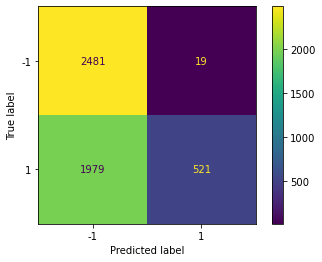

In [28]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.05)

train_classifier(('OneClassSVM', model), X_train, y_train, X_test, y_test)

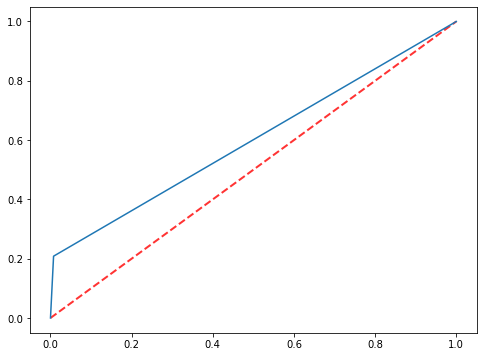

In [29]:


fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# then you can plot(fpr, tpr) to get the roc curve and compute the AUC with:
AUC = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8,6))
# plot the roc curve
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % AUC)


## Misused Detection (Machine Learning Algorithms)

In [136]:
# import libraries



In [118]:
df = pd.read_csv('data_cleaned.csv')

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,2,23,9,302,1023,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0
1,0,3,41,9,48,48,0,0,0,0,...,9,0.08,0.02,0.08,0.00,0.0,0.0,0.0,0.0,0
2,0,2,23,9,334,2096,0,0,0,0,...,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0,0
3,0,2,23,9,211,1796,0,0,0,0,...,255,1.00,0.00,0.05,0.04,0.0,0.0,0.0,0.0,0
4,0,2,23,9,210,396,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0


In [131]:
# 0 for normal conn., 1 for abnormal conn.
y = df['target']
X = df.drop(['target'], axis=1)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [144]:

def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()


In [146]:
# refered to code: https://amirhessam88.github.io/roc-vs-pr/
def plot_prc_curve(classifier, X, y, n_folds=5):
    """
    Function to:
    1. train RF classification model using cross-validation, 
    2. plot PRC curve, and 
    3. get avg F1 score
    """
    
    cv = StratifiedKFold(n_splits=n_folds)

    # defining the lists
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    f1_score_lst = []
    
    plt.figure(figsize=(9, 7))
    index = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train].values.ravel()).predict_proba(X.iloc[test])
        # Compute PR curve and area under the curve (prc/auc)
        precision, recall, thresholds = precision_recall_curve(y.iloc[test], probas_[:, 1])
        prs.append(np.interp(mean_recall, precision, recall))
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
        
        # append f1 score
        y_pred = classifier.predict(X.iloc[test])
        rf_f1 = f1_score(y_true=y.iloc[test], y_pred=y_pred)
        f1_score_lst.append(rf_f1)
        
        plt.plot(recall, precision, lw=1, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (index+1, pr_auc))
        index += 1
    
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='k', label='No Skill', alpha=.8)
    mean_precision = np.mean(prs, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    f1_array = np.array(f1_score_lst)
    print(f"average F1-scores: {np.mean(f1_array)}")
    plt.plot(mean_precision, mean_recall, color='navy',
             label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2)
    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=30)
    plt.ylabel('Precision',fontweight = "bold" , fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend( prop={'size':20} , loc = 0)
    plt.show()

### RandomForest Classifier


============================== Random Forest Model Evaluation ==============================

Cross Validation Mean Score:
 0.9969999999999999

Model Accuracy:
 0.9973

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       0.99      0.98      0.99      1210

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000




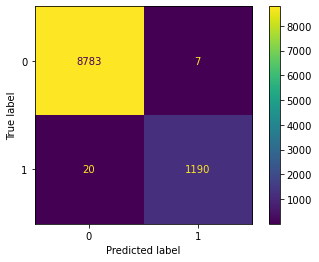

In [145]:


train_classifier(("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)), X_train.iloc[:10000, :], y_train.iloc[:10000], X_test.iloc[:10000, :], y_test.iloc[:10000])

average F1-scores: 0.9828717630577206


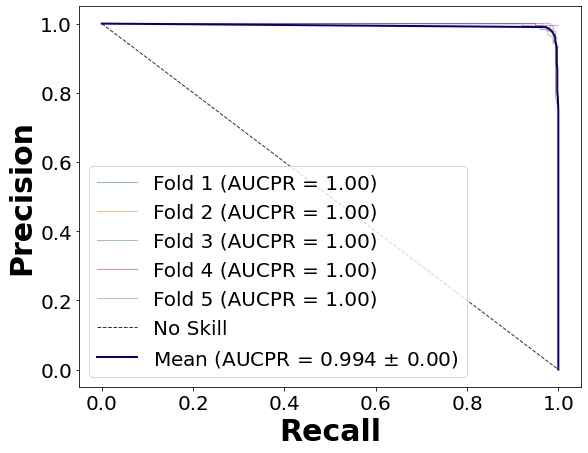

In [147]:
# get first 10000 data of X
X = X.iloc[:10000, :]
# get first 10000 data of y
y = y.iloc[:10000]

classifier = RandomForestClassifier(n_estimators=200)
plot_prc_curve(classifier, X, y)

## XGBoost Classifier


============================== XGBoost Model Evaluation ==============================

Cross Validation Mean Score:
 0.9971

Model Accuracy:
 0.9977

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      0.99      0.99      1210

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000




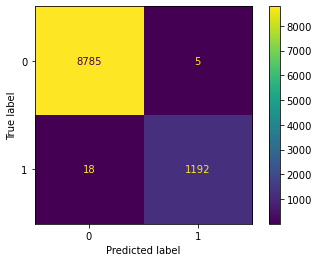

In [150]:

# Train XGBoost Classifier
xgbc = XGBClassifier(eval_metric="logloss", random_state=42)


train_classifier(("XGBoost", xgbc), X_train.iloc[:10000, :], y_train.iloc[:10000], X_test.iloc[:10000, :], y_test.iloc[:10000])

average F1-scores: 0.9772129843488738


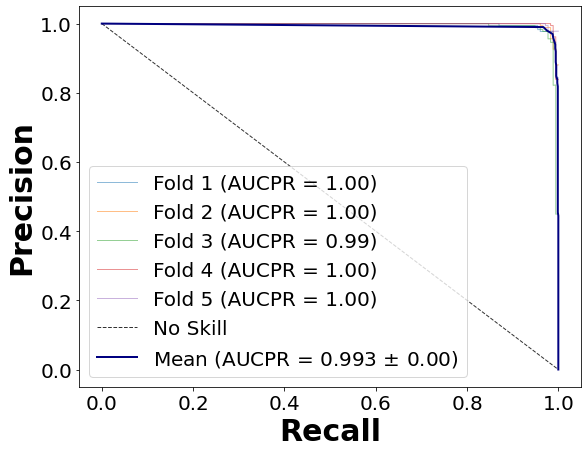

In [151]:
# get first 10000 data of X
X = X.iloc[:10000, :]
# get first 10000 data of y
y = y.iloc[:10000]

plot_prc_curve(xgbc, X, y)